<a href="https://colab.research.google.com/github/Rauchdimehdi/ComputerVisionOpenCv/blob/master/SetSolverHub_V3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Transfer Learning to implement a program that can play a card game called SET

---



#Load our Dataset




Let's upload our dataset that we did put in the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/DataSetJeuSet_V1')

In [0]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"le nombre dimage est :{image_count}")
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(f'les noms des classes sont : {CLASS_NAMES}')

**Let's load using Keras preprocessing**

In [31]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  zoom_range=0.2,
                                                                  validation_split=0.2)


#Loader Parametres
Taille_BATCH = 32
BATCH_SIZE = Taille_BATCH
IMG_SIZE = 160
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='training')

validation_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='validation')
# next(train_data_gen)

Found 1622 images belonging to 81 classes.
Found 404 images belonging to 81 classes.


In [0]:
# INSPECT THE BATCH
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(Taille_BATCH):
      ax = plt.subplot(8,6,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [33]:
image_batch, label_batch = next(train_data_gen)
image_batch.shape
# show_batch(image_batch, label_batch)
# bel_batch.tolist()


(32, 160, 160, 3)

**Performance**

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [0]:
# `keras.preprocessing`
# timeit(train_data_gen)

**Create the base model from the pre-trained convnets**

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [35]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [0]:
base_model.trainable = False


In [0]:
# Let's take a look at the base model architecture
base_model.summary()


In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [39]:
prediction_layer = tf.keras.layers.Dense(train_data_gen.num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 81)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [0]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



In [43]:
len(model.trainable_variables)


2

# Training the model

In [45]:
num_train = train_data_gen.samples
initial_epochs = 10
# steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = validation_data_gen.samples // BATCH_SIZE
loss0,accuracy0 = model.evaluate(validation_data_gen, steps = validation_steps)


  ...
    to  
  ['...']
12/12 [==============================] - 10s 852ms/step - loss: 4.9061 - accuracy: 0.0104


In [46]:
history = model.fit(train_data_gen,
                    steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
                    validation_data=validation_data_gen,
                    validation_steps = validation_data_gen.samples // BATCH_SIZE,
                    epochs=initial_epochs)

# history = model.fit_generator(
#     train_data_gen,
#     steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
#     validation_data = validation_data_gen, 
#     validation_steps = validation_data_gen.samples // BATCH_SIZE,
#     epochs = initial_epochs)

# train_data_gen.samples

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 12 steps
Epoch 1/10
50/50 [==============================] - 163s 3s/step - loss: 6.5478 - accuracy: 0.1943 - val_loss: 7.8708 - val_accuracy: 0.0495
Epoch 2/10
50/50 [==============================] - 163s 3s/step - loss: 1.9876 - accuracy: 0.5456 - val_loss: 8.4482 - val_accuracy: 0.0469
Epoch 3/10
50/50 [==============================] - 160s 3s/step - loss: 1.2172 - accuracy: 0.6862 - val_loss: 12.0797 - val_accuracy: 0.0339
Epoch 4/10
50/50 [==============================] - 163s 3s/step - loss: 1.0102 - accuracy: 0.7560 - val_loss: 12.2330 - val_accuracy: 0.0547
Epoch 5/10
50/50 [==============================] - 162s 3s/step - loss: 0.7219 - accuracy: 0.8252 - val_loss: 11.4289 - val_accuracy: 0.0599
Epoch 6/10
50/50 [==============================] - 161s 3s/step - loss: 0.6464 - accuracy: 0.8447 - val_loss: 10.7795 - val_accuracy: 0.0677
Epoch 7/10
50/50 [==============================] - 162s 3

**Testing our model**

In [47]:
image_batch, label_batch = next(train_data_gen)
pred_batch = model.predict(image_batch)
pred_batch.shape
pred_id=np.argmax(pred_batch,axis=-1)
print(pred_id)
pred_label_batch=CLASS_NAMES[pred_id]
# pred_label_batch

[11 20 54  7  5  5  7  5 25  7  5 20  5  5 50  5 20 20  5 20 54  5  5  5
  5 20 20  5  5  5 20  5]


In [0]:
label_id = np.argmax(label_batch, axis=-1)


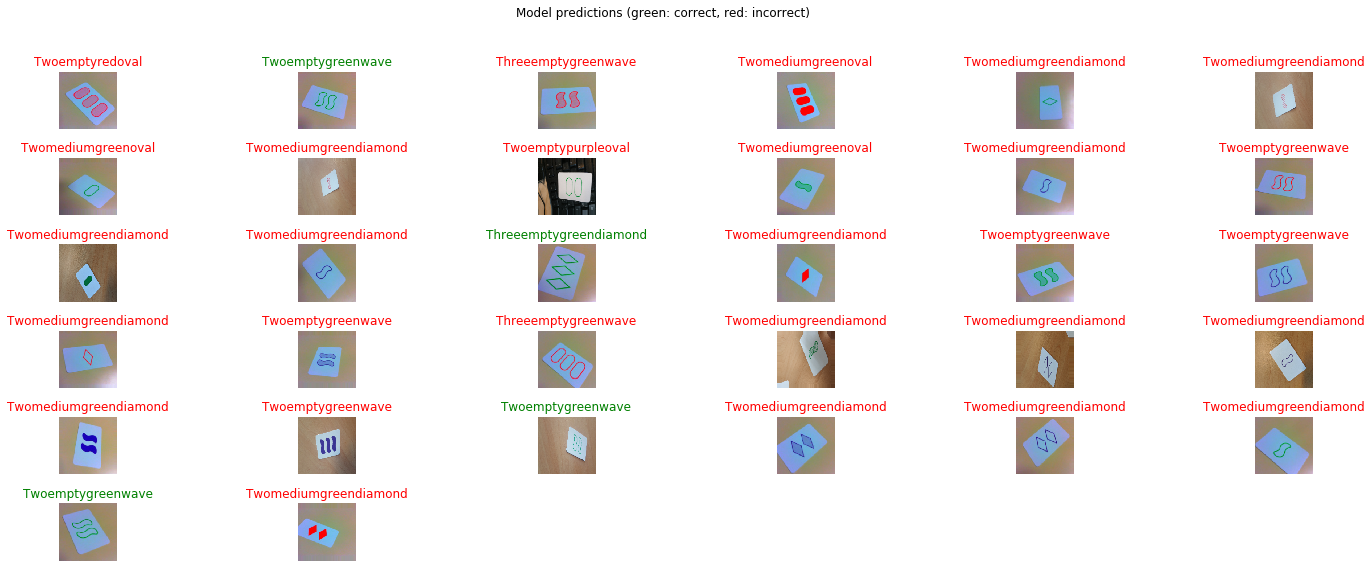

In [49]:
plt.figure(figsize=(25,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  color = "green" if pred_id[n] == label_id[n] else "red"
  plt.title(pred_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


**lEARNING CURVES**

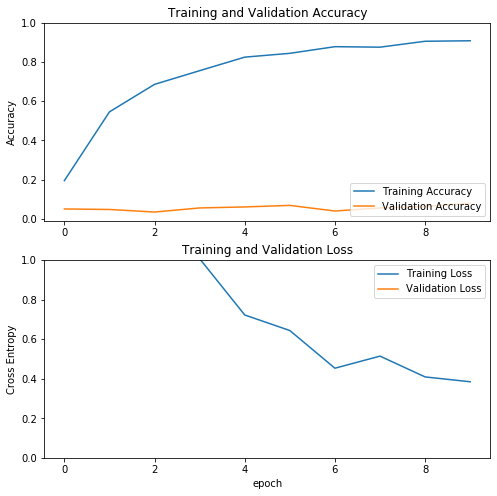

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [0]:
# model.save('/content/drive/My Drive/SetSolver Folder/SetSolverModel_v1.h5')

In [0]:
# from tensorflow.keras.models import load_model
# newModel= load_model("/content/drive/My Drive/SetSolver Folder/SetSolverModel_v1.h5")

In [0]:
# newModel.summary()

In [0]:
# # Test with our model where we trained only on 5 photos per class
# pred_batch=newModel.predict(image_batch)
# print(pred_batch[0])
# pred_id=np.argmax(pred_batch,axis=-1)

# print(pred_id)
# pred_label_batch=CLASS_NAMES[pred_id]
# # pred_label_batch

# **Fine Tuning**

In [0]:
# Un-freeze the top layers of the model
base_model.trainable = True


In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  155


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [54]:
len(model.trainable_variables)


58

In [55]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_data_gen)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 51 steps, validate for 13 steps
Epoch 10/20
51/51 [==============================] - 190s 4s/step - loss: 2.2233 - accuracy: 0.6184 - val_loss: 41.2500 - val_accuracy: 0.0248
Epoch 11/20
51/51 [==============================] - 182s 4s/step - loss: 0.9019 - accuracy: 0.7885 - val_loss: 36.1889 - val_accuracy: 0.0322
Epoch 12/20
51/51 [==============================] - 182s 4s/step - loss: 0.6724 - accuracy: 0.8360 - val_loss: 40.2243 - val_accuracy: 0.0668
Epoch 13/20
51/51 [==============================] - 185s 4s/step - loss: 0.5284 - accuracy: 0.8792 - val_loss: 47.2714 - val_accuracy: 0.0297
Epoch 14/20
51/51 [==============================] - 180s 4s/step - loss: 0.4139 - accuracy: 0.8970 - val_loss: 44.0995 - val_accuracy: 0.0446
Epoch 15/20
51/51 [==============================] - 182s 4s/step - loss: 0.3169 - accuracy: 0.9236 - val_loss: 39.5353 - val_accuracy: 0.0842
Epoch 16/20
51/51 [==============================]

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


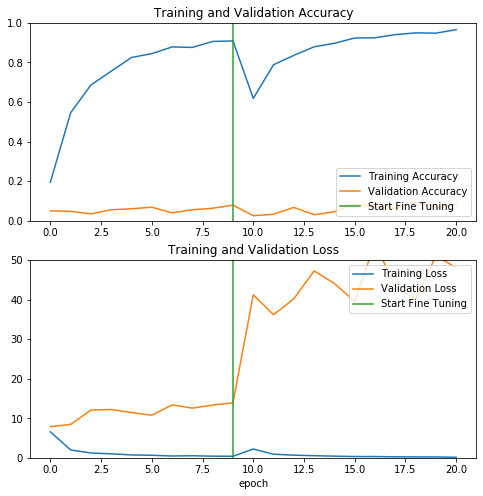

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 50])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Test after Tuning**

In [58]:
image_batch, label_batch = next(train_data_gen)
pred_batch = model.predict(image_batch)
pred_batch.shape
pred_id=np.argmax(pred_batch,axis=-1)
print(pred_id)
pred_label_batch=CLASS_NAMES[pred_id]

[51 41 52 25 25 51 52 17 51 76 41 41 51 52 51 52 51 41 58 50 79 51 51 52
 58 51 41 51 52 25 76 58]


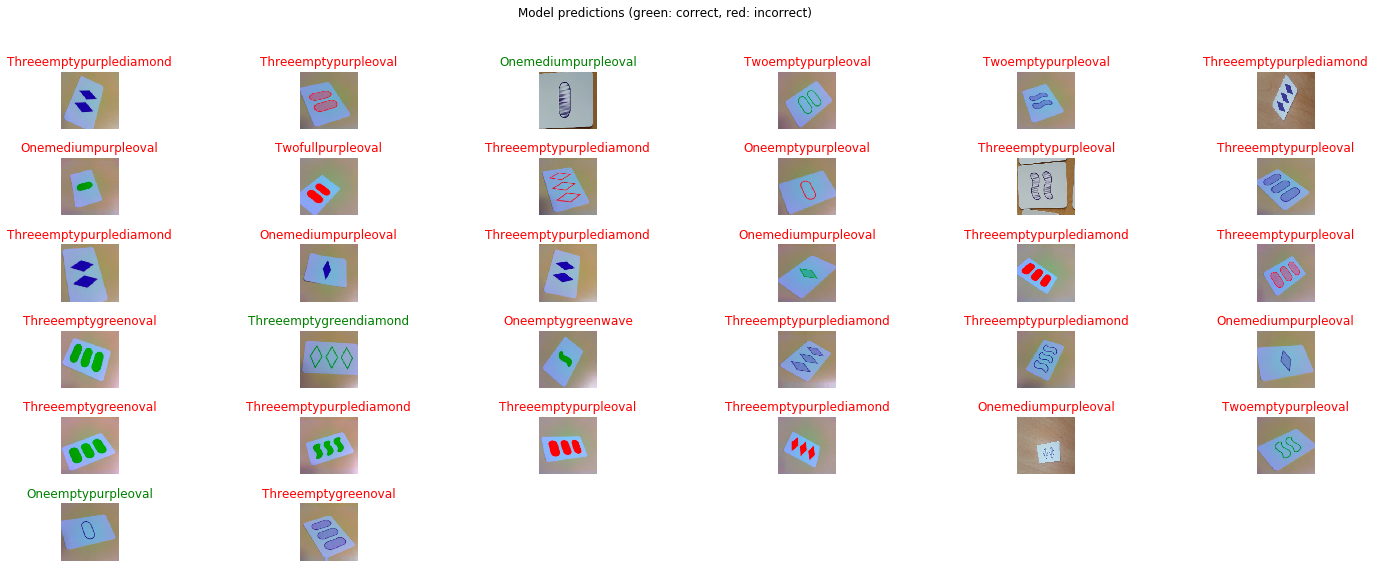

In [59]:
label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(25,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(image_batch[n])
  color = "green" if pred_id[n] == label_id[n] else "red"
  plt.title(pred_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
